In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense,RepeatVector, Concatenate, Layer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/apple_share_price.csv',usecols=[1,2,3,4])
dataset = dataset.reindex(index = dataset.index[::-1])
print(dataset)

        Open    High     Low   Close
1663   46.52   47.18   46.41   47.08
1662   47.49   47.50   46.88   47.33
1661   47.08   47.76   47.07   47.71
1660   47.82   47.89   47.56   47.68
1659   47.71   48.05   47.41   48.02
...      ...     ...     ...     ...
4     157.06  158.92  156.67  158.81
3     158.60  161.83  158.27  160.08
2     159.26  161.27  159.11  161.06
1     159.90  160.00  154.63  155.32
0     156.60  158.57  156.07  157.48

[1664 rows x 4 columns]


In [ ]:
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:],dataset[train_size:len(dataset),:]

In [ ]:
# split a multivariate sequence into samples
def create_dataset(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(sequences)-1:
      break
  # gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)

(1112, 2, 4)


In [ ]:
#properly intialize all the parameters
class BahdanauAttention(Layer):# parent class
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)#neural network of  encoder to extract the features in the keys
    self.W2 = Dense(units)#neural network of  decoder " queries
    self.V = Dense(1)# attention score calculated
  def call(self, values, query):
    # values shape == (batch_size, max_len, hidden_size)# parellel aayitt process chyuum whatever the vallue of batch size, length of the statement denotes max length,
    # query shape == (batch_size, hidden_size)
    query_with_time_axis = tf.expand_dims(query, 1)# to equalize the dimentions of both query and values
    # Calculate the attention scores
    score = tf.nn.tanh(self.W1(values) + self.W2(query_with_time_axis))#allighnmet score calculated as dot product
    attention_weights = tf.nn.softmax(self.V(score), axis=1)# weight that assighns to the inpu sequence for which each word how much significant is
    # Calculate the context vector
    context_vector = attention_weights * values#context vector
    context_vector = tf.reduce_sum(context_vector, axis=1)# if the patch size is one then we can avoid this step
    return context_vector, attention_weights

In [ ]:
def build_encoder_decoder_model(input_shape, lstm_units):
# Encoder
  encoder_inputs = Input(shape=input_shape)
  encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
  encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# Attention layer
  attention_layer = BahdanauAttention(lstm_units)
  context_vector, attention_weights = attention_layer(encoder_outputs, state_h)
# Decoder
  decoder_lstm = LSTM(lstm_units, return_sequences=False, return_state=False)
  decoder_outputs = decoder_lstm(tf.expand_dims(context_vector, 1),initial_state=[state_h, state_c])
  decoder_dense = Dense(4) # Predicting all four features
  final_output = decoder_dense(decoder_outputs)
  model = Model(inputs=encoder_inputs, outputs=final_output)
  return model

In [ ]:
import tensorflow as tf
sequence_length = 2
model =build_encoder_decoder_model(input_shape=(sequence_length, 4),lstm_units=50) # 4 features: Open, High, Low, Close
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(trainX, trainY, epochs=30, batch_size=16,
validation_split=0.2)

# Make predictions
predicted = model.predict(trainX)

trainPredict = scaler.inverse_transform(predicted)
trainY = scaler.inverse_transform(trainY)
print(trainPredict)

Epoch 1/30
56/56 [==============================] - 7s 24ms/step - loss: 0.0181 - val_loss: 0.0161
Epoch 2/30
56/56 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 3/30
56/56 [==============================] - 0s 7ms/step - loss: 2.6158e-04 - val_loss: 0.0055
Epoch 4/30
56/56 [==============================] - 0s 8ms/step - loss: 2.2032e-04 - val_loss: 0.0033
Epoch 5/30
56/56 [==============================] - 0s 7ms/step - loss: 2.0819e-04 - val_loss: 0.0040
Epoch 6/30
56/56 [==============================] - 0s 6ms/step - loss: 1.8819e-04 - val_loss: 0.0011
Epoch 7/30
56/56 [==============================] - 0s 6ms/step - loss: 1.7021e-04 - val_loss: 0.0011
Epoch 8/30
56/56 [==============================] - 0s 6ms/step - loss: 1.6262e-04 - val_loss: 6.6339e-04
Epoch 9/30
56/56 [==============================] - 0s 6ms/step - loss: 1.5410e-04 - val_loss: 2.3793e-04
Epoch 10/30
56/56 [==============================] - 0s 7ms/step - loss: 1.5096e-

In [ ]:
trainScore =math.sqrt(mean_squared_error(trainY,trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))

testPredict = model.predict(testX)

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

Train Score: 1.75 RMSE
18/18 [==============================] - 0s 2ms/step


In [ ]:
testScore = math.sqrt(mean_squared_error(testY,testPredict))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] =trainPredict

Test Score: 4.22 RMSE


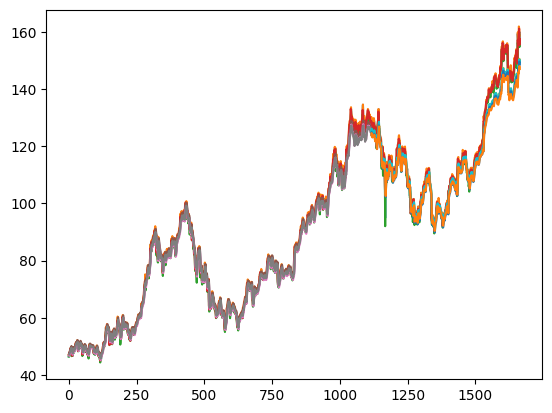

In [ ]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset),:] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()